In [40]:
%matplotlib inline
import numpy as np
from keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from preprocessing import *

# to autoreload modules on code change
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


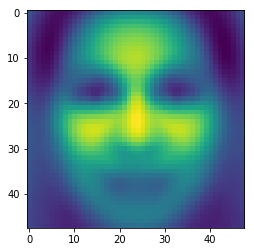

In [55]:
X_train, y_train, X_val, y_val, X_test, y_test = get_emotion_data(scale=True)

In [25]:
for j,i in enumerate([X_train, y_train, X_val, y_val, X_test, y_test]):
    print(i.shape)
    if j%2 != 0:
        print('----------------------------------------')
        bc = np.bincount(i.astype(int).reshape(-1))
        sm = bc.sum()
        print(bc/sm) # to check if sampling is stratified
        print()

(28709, 2304)
(28709, 1)
----------------------------------------
[ 0.13915497  0.01518688  0.14270786  0.25131492  0.16823992  0.11045317
  0.17294228]

(3589, 2304)
(3589, 1)
----------------------------------------
[ 0.13011981  0.01560323  0.13820006  0.24937308  0.18194483  0.1156311
  0.16912789]

(3589, 2304)
(3589, 1)
----------------------------------------
[ 0.13680691  0.0153246   0.14711619  0.24491502  0.16550571  0.11590972
  0.17442184]



In [62]:
datagen = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

datagen.fit(X_train.reshape(-1,48,48,1))

In [63]:
dl = datagen.flow(X_train, y_train, batch_size=32),steps_per_epoch=len(X_train) / 32, epochs=epochs)

IndentationError: unexpected indent (<ipython-input-63-004ca4a85eae>, line 2)

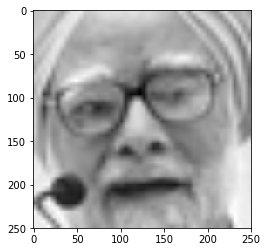

In [60]:
img = X_train[1].reshape(48,48)/255
img = cv2.resize(img,(250,250))
plt.imshow(img,cmap='gray')


In [61]:
img

array([[ 0.1204178 ,  0.1204178 ,  0.1204178 , ...,  0.00373634,
         0.00373634,  0.00373634],
       [ 0.1204178 ,  0.1204178 ,  0.1204178 , ...,  0.00373634,
         0.00373634,  0.00373634],
       [ 0.1204178 ,  0.1204178 ,  0.1204178 , ...,  0.00373634,
         0.00373634,  0.00373634],
       ..., 
       [ 0.26884607,  0.26884607,  0.26884607, ...,  0.27325297,
         0.27325297,  0.27325297],
       [ 0.26884607,  0.26884607,  0.26884607, ...,  0.27325297,
         0.27325297,  0.27325297],
       [ 0.26884607,  0.26884607,  0.26884607, ...,  0.27325297,
         0.27325297,  0.27325297]])